<a href="https://colab.research.google.com/github/lucamatteucci10/BA820-team-10/blob/main/Project%20820/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Twitter Sentiment Analysis**

**Team 10**

* Luca Matteucci
* Neeharika Kamireddy
* Haaniya Umair
* Sneha Jayapradeep
* Chirayu (Mitthi) Jain

## Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize.casual import TweetTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix


## Mounting the Drive and Loading the Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Data_project_820/Tweet_data.csv', encoding='ISO-8859-1', names=['polarity', 'id', 'date', 'query', 'user', 'text'])
df.head()

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Let's dive into the dataset a bit more. We have 1.6M rows and 6 attributes.

## Exploring the Dataset

In [5]:
df.shape

(1600000, 6)

We can also dive in to check for any null values and learn what kind of datatypes are in each column.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   polarity  1600000 non-null  int64 
 1   id        1600000 non-null  int64 
 2   date      1600000 non-null  object
 3   query     1600000 non-null  object
 4   user      1600000 non-null  object
 5   text      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


It looks like we have two numerical columns and the rest are objects/text. It seems that there are no null values either, but let's just double check to make sure.

## Data Cleaning

In [7]:
df.isna().sum()

polarity    0
id          0
date        0
query       0
user        0
text        0
dtype: int64

There are no null values so let's look at the distribution for the numerical columns.

In [8]:
df.describe()

,polarity,id
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [9]:
df['polarity'].unique()

array([0, 4])

The polarity looks a bit off and by digging in deeper we learn its because the assigned values are either 0 or 4, to make it easier for us to understand the dataset, we will replace it with 0 and 1.

In [10]:
df['polarity'] = df['polarity'].replace({4: 1})

In [11]:
df.describe()

,polarity,id
count,1600000.0,1.600000e+06
mean,0.5,1.998818e+09
std,0.5,1.935761e+08
min,0.0,1.467810e+09
25%,0.0,1.956916e+09
50%,0.5,2.002102e+09
75%,1.0,2.177059e+09
max,1.0,2.329206e+09


Now we want to check for any duplicates in any of the rows to make sure the 1.6M rows are unique tweets instead of duplicates.

In [12]:
df.duplicated().sum()

0

Looks like we have no duplicate tweets, which is great. Now we can check for how many unique users we have in the dataset.

In [13]:
df['user'].nunique()

659775

## EDA

###Top 10 Users by Tweet Count

There are over 600,000 users, so while we can't plot how many tweets each user has, we can definitely dive into the top 10 users in the dataset and see weather they had mostly positive or negative tweets.

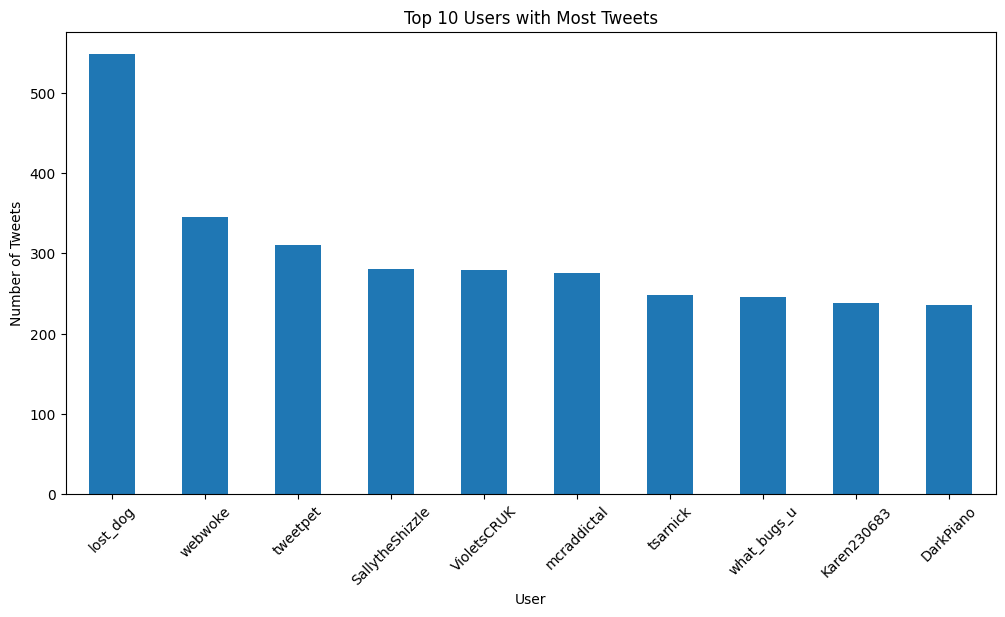

In [14]:
top_users = df['user'].value_counts().nlargest(10)
plt.figure(figsize=(12, 6))
top_users.plot(kind='bar')
plt.xlabel('User')
plt.ylabel('Number of Tweets')
plt.title('Top 10 Users with Most Tweets')
plt.xticks(rotation=45)
plt.show()

### Sentiment Breakdown: Top 10 Users

<Figure size 1200x600 with 0 Axes>

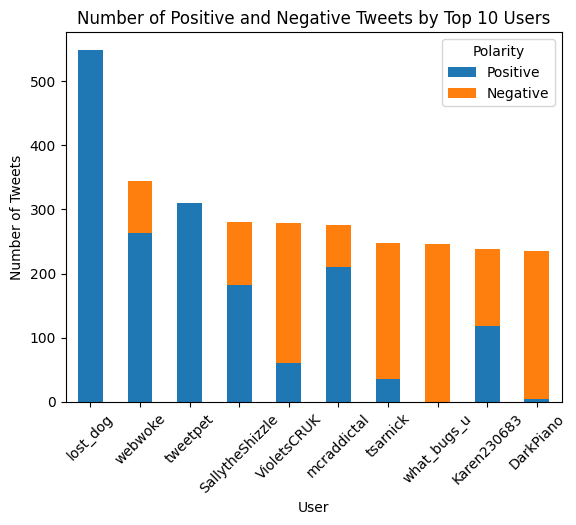

In [15]:
top_users = df['user'].value_counts().nlargest(10).index
top_users_df = df[df['user'].isin(top_users)]
counts = top_users_df.groupby(['user', 'polarity']).size().unstack(fill_value=0)
counts['total_tweets'] = counts.sum(axis=1)
counts = counts.sort_values(by='total_tweets', ascending=False)
plt.figure(figsize=(12, 6))
counts.drop('total_tweets', axis=1).plot(kind='bar', stacked=True)
plt.xlabel('User')
plt.ylabel('Number of Tweets')
plt.title('Number of Positive and Negative Tweets by Top 10 Users')
plt.xticks(rotation=45)
plt.legend(title='Polarity', labels=['Positive', 'Negative'])
plt.show()

We can also dive in to see weather the dataset has mostly positive, or mostly negative tweets - to guage the overall sentiment analysis at a first glance.

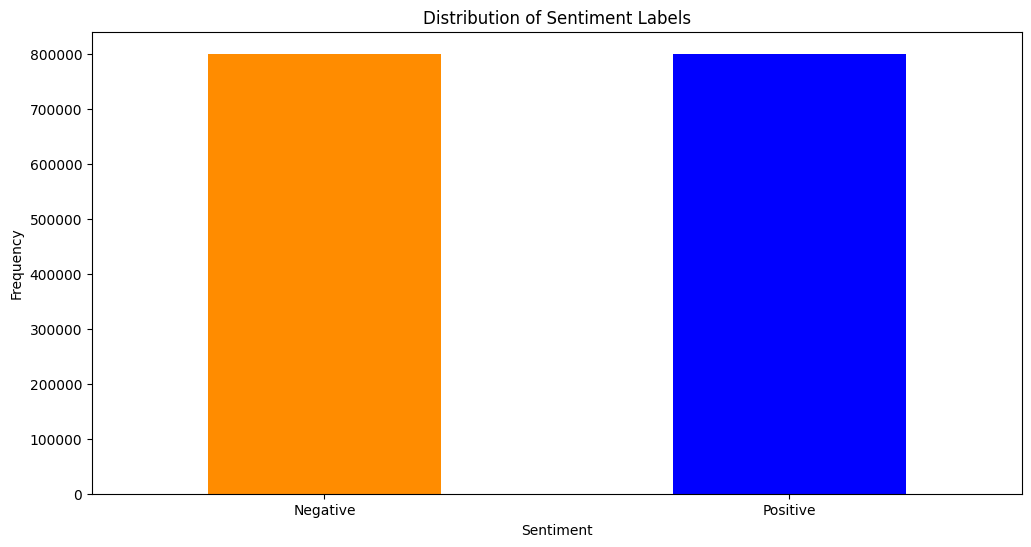

Proportion of Positive Tweets: 50.00%
Proportion of Negative Tweets: 50.00%


In [16]:
sentiment_counts = df['polarity'].value_counts()

plt.figure(figsize=(12, 6))
sentiment_counts.plot(kind='bar', color=['darkorange', 'b'])
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Labels')
plt.xticks(rotation=0, ticks=[0, 1],labels=['Negative', 'Positive'])
plt.show()

positive_tweets = sentiment_counts[1]
negative_tweets = sentiment_counts[0]
positive_percentage = (positive_tweets / sentiment_counts.sum()) * 100
negative_percentage = (negative_tweets / sentiment_counts.sum()) * 100
print(f"Proportion of Positive Tweets: {positive_percentage:.2f}%")
print(f"Proportion of Negative Tweets: {negative_percentage:.2f}%")

Looks like theres exactly the same number of positive and negative tweets, and none that were classified as neutral. This does not seem like something we would authentically find in a dataset, so I think maybe the datashit was conditioned to classify all its tweets equally into one or the other. This probably means that a lot of 'neutral' tweets were incorrectly classified.

## Text Cleaning

In [38]:
#Sample to 1.75% of the dataset for faster processing
df_new = df.sample(frac=0.0175, random_state=42)
df_new

,polarity,id,date,query,user,text
541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem
...,...,...,...,...,...,...
666366,0,2245254084,Fri Jun 19 15:52:26 PDT 2009,NO_QUERY,likegallows,@kikidangerously i hope you feel better and p...
761389,0,2297213473,Tue Jun 23 10:09:57 PDT 2009,NO_QUERY,VicStiX,@Irishgal719 Dang I haven't been able to follo...
661271,0,2243070530,Fri Jun 19 12:59:21 PDT 2009,NO_QUERY,Chief_Ben,wen boredom strikes there is but one thing a m...
499996,0,2186710108,Mon Jun 15 19:13:32 PDT 2009,NO_QUERY,vibzfabz,"@heyitsMade : I have no idea, I'm using web no..."


In [18]:
# convert every character to lower case.
df_new['text'] = df_new['text'].str.lower()

In [19]:
http_texts = df_new[df_new['text'].str.startswith('http')]

print(http_texts)

         polarity          id                          date     query  \
1108196         1  1971694036  Sat May 30 07:41:17 PDT 2009  NO_QUERY   
870302          1  1678338430  Sat May 02 06:22:48 PDT 2009  NO_QUERY   
783542          0  2323944710  Thu Jun 25 01:53:23 PDT 2009  NO_QUERY   
537274          0  2198707463  Tue Jun 16 16:27:25 PDT 2009  NO_QUERY   
629217          0  2231568837  Thu Jun 18 18:43:49 PDT 2009  NO_QUERY   
...           ...         ...                           ...       ...   
1599857         1  2193552692  Tue Jun 16 08:36:48 PDT 2009  NO_QUERY   
359656          0  2045919223  Fri Jun 05 11:25:52 PDT 2009  NO_QUERY   
1267160         1  1999801315  Mon Jun 01 20:50:52 PDT 2009  NO_QUERY   
840511          1  1559772281  Sun Apr 19 12:00:38 PDT 2009  NO_QUERY   
397671          0  2056690961  Sat Jun 06 11:36:47 PDT 2009  NO_QUERY   

                   user                                               text  
1108196           suffe  http://mobypicture.co

In [20]:
# remove URL links but keeps the rows
df_new['text'] = df_new['text'].str.replace(r'http\S+', '', regex=True)


In [21]:
# check for URL removal
df_new.loc[870302]

polarity                                                    1
id                                                 1678338430
date                             Sat May 02 06:22:48 PDT 2009
query                                                NO_QUERY
user                                           kayotickitchen
text         - before his hair cut. i just wanna kiss that...
Name: 870302, dtype: object

In [22]:
import re

def clean_text(text):
    # Regular expression to match emojis and old school emoji
    emoji_pattern = re.compile("["      # This pattern has been generated with the help of AI
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
        "]+|[:;=]-?[)DpPoO(/\\|*]"  # Additional pattern for old school emoji of this kind ":), ;)"
        , flags=re.UNICODE)

    # This function check if a string contains an emoji
    def contains_emoji(s):
        return emoji_pattern.search(s) is not None

    # Define a pattern to match the unwanted characters, while keeping traditional emoticons and emojis
    unwanted_chars_pattern = r'[^a-zA-Z0-9\s]+'

    # Split the text into words and symbols and Rebuild the text keeping emojis and alpha numerical characters
    split_text = re.findall(r'\w+|[^\w\s]|[\s]', text, re.UNICODE)


    cleaned_text = ''.join([word if contains_emoji(word) or re.match(unwanted_chars_pattern, word) is None or word.isspace() else ' ' for word in split_text])

    return cleaned_text.strip()

In [23]:
# Cleaning from unwanted characters
df_new['text'] = df_new['text'].apply(clean_text)

Check if there are tweets with URLs.

In [24]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28000 entries, 541200 to 1558639
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   polarity  28000 non-null  int64 
 1   id        28000 non-null  int64 
 2   date      28000 non-null  object
 3   query     28000 non-null  object
 4   user      28000 non-null  object
 5   text      28000 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.5+ MB


## Preliminary Analysis

### Tokenization

We used tokenization to break down the text into individual words or tokens, making it easier to analyze and process the text.

In [25]:
# Tokenize converting all tweets to lower case, eliminating tweet username and reducing lenght of word like niiiiiiiceeeeee to nice
import nltk

tknzr = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

tokenized = [tknzr.tokenize(t) for t in df_new['text']]


In [26]:
# Remove stop words from each tweet
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
filtered_tokens = [[word for word in tweet if word not in stop_words] for tweet in tokenized]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Stemming and lemmatization

 Stemming and lemmatization were employed to reduce words to their root form, this is to ensure consistency and reduce dimensionality in our analysis.



In [27]:
# Stemming
stemmer = PorterStemmer()

stemmed_tokens = [[stemmer.stem(word) for word in tweet] for tweet in filtered_tokens]

In [28]:
# Lemmatization
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

lemmatized_tokens = [[lemmatizer.lemmatize(word) for word in tweet] for tweet in filtered_tokens]

[nltk_data] Downloading package wordnet to /root/nltk_data...


### Bag of Words

Even though BoW does not account for the word order or context, we want to use it as baseline model for sentiment analysis. We want to determine the frequency of specific words in the dataset, hoping that we can identify common themes and keywords to gauge sentiments.

In [29]:
# Join the stemmed tokens back into strings
stemlem_texts = [" ".join(tokens) for tokens in lemmatized_tokens]
vectorizer = CountVectorizer()
BoW_matrix = vectorizer.fit_transform(stemlem_texts)
BoW_df = pd.DataFrame(BoW_matrix.toarray(), columns=vectorizer.get_feature_names_out())
BoW_df

,00,000,000th,001,0013,002,004,007,008,00am,...,zuzubrandy,zwagger,zwalkk,zxch,zxcv,zxed,zycam,zyrtec,zz,zzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
word_freq = BoW_df.sum(axis = 0).sort_values(ascending = False)
word_freq

day            1822
good           1601
get            1518
like           1392
go             1367
               ... 
indulge           1
induced           1
indo              1
indifferent       1
located           1
Length: 34999, dtype: int64

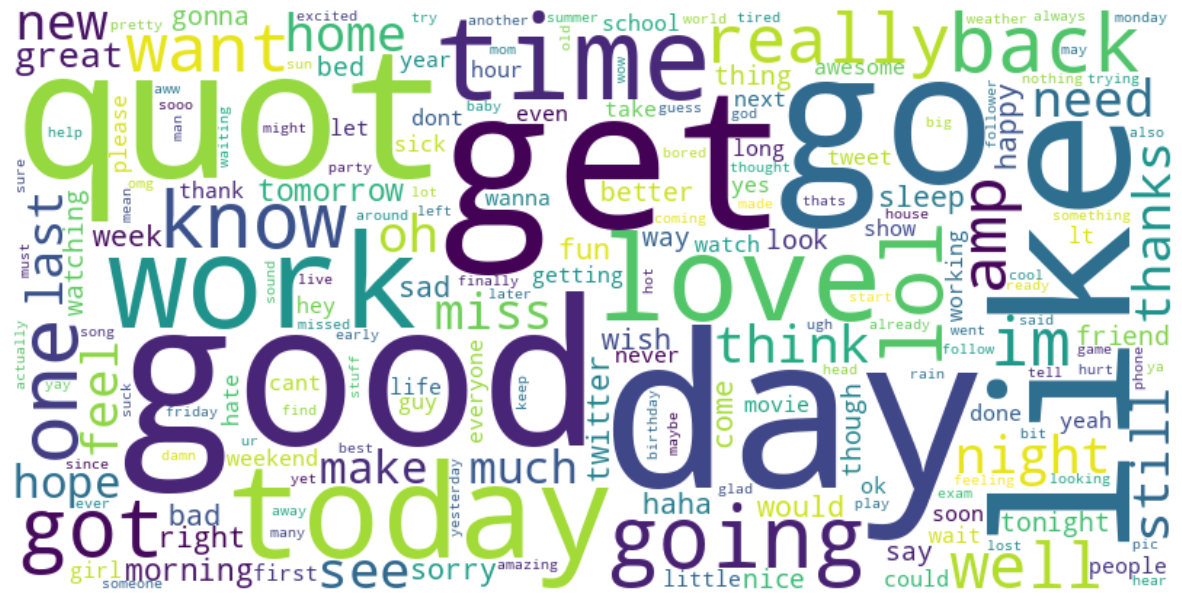

In [39]:
#Wordcloud
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In the figure above we can see our preliminary ‘WordCloud’ using BoW, it doesn’t seem the most useful for sentiment analysis as we cannot gather any insights related to sentiments of the tweets. We do see words such as ‘love’, ‘like’, ‘good’ - but again, since context was not considered in BoW it is hard to draw any conclusions about the sentiment.

### TF - IDF

TF-IDF was used to improve upon BoW by taking into account the importance of words not just the individual words but also their context in the entire dataset. This helped us identify more 'discriminative' features for sentiment classification.

In [32]:
tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(stemlem_texts)

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df

,00,000,000th,001,0013,002,004,007,008,00am,...,zuzubrandy,zwagger,zwalkk,zxch,zxcv,zxed,zycam,zyrtec,zz,zzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
tfidf_sparse = csr_matrix(tfidf_df.values)
cos_sim_sparse = cosine_similarity(tfidf_sparse, tfidf_sparse)
cos_sim_df = pd.DataFrame(cos_sim_sparse)
cos_sim_df

,0,1,2,3,4,5,6,7,8,9,...,27990,27991,27992,27993,27994,27995,27996,27997,27998,27999
0,1.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.091719,0.0,0.0,0.0,0.000000,0.08767,0.000000,0.0,0.000000,0.0
1,0.00000,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0
2,0.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.046186,0.0,0.025264,...,0.000000,0.0,0.0,0.0,0.046324,0.00000,0.000000,0.0,0.000000,0.0
3,0.00000,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0
4,0.00000,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0.08767,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.227949,0.0,0.0,0.0,0.000000,1.00000,0.000000,0.0,0.000000,0.0
27996,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.00000,1.000000,0.0,0.034965,0.0
27997,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,1.0,0.000000,0.0
27998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.034965,0.0,1.000000,0.0


In [34]:
text_in_row_2 = df_new.iloc[3]['text']
text_in_column_7 = df_new.iloc[8]['text']

print("Text in row 2:", text_in_row_2)
print("Text in column 7:", text_in_column_7)

Text in row 2: school email won t open  and i have geography stuff on there to revise   stupid school
Text in column 7: gahh noo peyton needs to live this is horrible


In [35]:
tfidf_word_freq = tfidf_df.sum(axis = 0).sort_values(ascending = False)
tfidf_word_freq

day       369.145919
good      343.961278
work      295.899801
get       282.919358
go        282.757964
             ...    
yungla      0.158674
stomp       0.151705
8o          0.134207
tgp         0.110432
snooow      0.068985
Length: 34999, dtype: float64

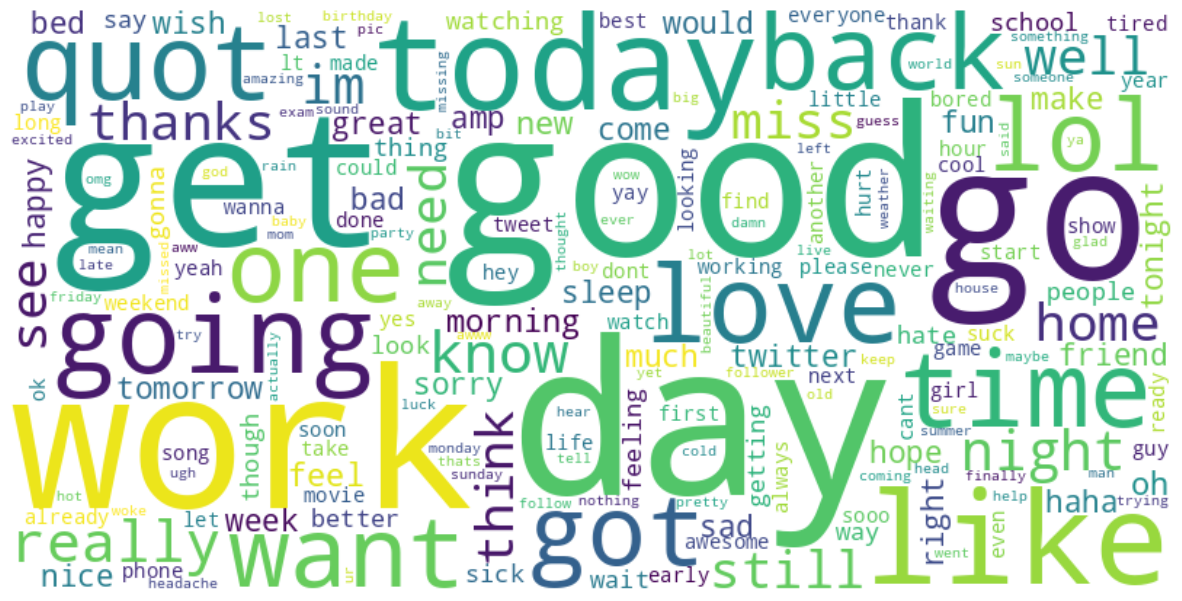

In [36]:
#Wordcloud
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate_from_frequencies(tfidf_word_freq)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The above figure is the “WordCloud" for TF-IDF, it is not that different from the BoW word cloud and as a result, not very helpful for sentiment analysis. But it is still helpful to see what kind of words are most common.

In [37]:
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np

import nltk
nltk.download('punkt')

tokenized_texts = [word_tokenize(text.lower()) for text in stemlem_texts]
word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1)

word_embeddings = word2vec_model.wv

document_vectors = []
for tokens in tokenized_texts:
     document_vector = [word_embeddings[word] for word in tokens if word in word_embeddings]
     if document_vector:
         document_vector = np.mean(document_vector, axis=0)
         document_vectors.append(document_vector)

document_vectors = np.array(document_vectors)
document_vectors
doc_vec=pd.DataFrame(document_vectors)
doc_vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.187548,0.306536,0.036783,-0.045449,0.129652,-0.830190,0.414115,1.098917,-0.415272,-0.470975,...,0.709137,0.404959,0.157948,0.141248,0.895402,0.597608,0.268719,-0.565186,0.117358,-0.043890
1,-0.168636,0.286663,0.085720,-0.011811,0.111125,-0.762004,0.326500,0.987214,-0.390699,-0.374166,...,0.601406,0.338280,0.145451,0.101496,0.777801,0.523351,0.175658,-0.522495,0.140281,-0.014371
2,-0.256628,0.387496,0.087867,-0.083143,0.153839,-0.979728,0.487412,1.285558,-0.502384,-0.503833,...,0.802892,0.489546,0.202954,0.156771,1.067708,0.709537,0.314441,-0.686744,0.176296,-0.073217
3,-0.155380,0.262203,0.096802,-0.002195,0.119190,-0.775318,0.317412,0.962530,-0.373003,-0.410308,...,0.625377,0.337215,0.107259,0.092020,0.768642,0.497068,0.164475,-0.523459,0.138387,-0.050682
4,-0.067009,0.104728,0.018487,-0.019024,0.037393,-0.246076,0.122095,0.345248,-0.118932,-0.128829,...,0.196401,0.115752,0.059246,0.045913,0.275211,0.192187,0.072645,-0.178719,0.044739,0.001171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27990,-0.201965,0.346348,-0.008499,-0.062816,0.131268,-0.862209,0.473582,1.165157,-0.430716,-0.501531,...,0.735391,0.415469,0.198612,0.161249,0.939411,0.631743,0.311498,-0.582047,0.122849,-0.037378
27991,-0.127766,0.258581,0.091493,0.035368,0.077711,-0.773634,0.300669,0.976854,-0.376310,-0.448772,...,0.644692,0.318529,0.111155,0.103003,0.762812,0.492744,0.154751,-0.512915,0.086037,-0.030857
27992,-0.174866,0.307786,0.040444,-0.048970,0.113513,-0.746750,0.387312,0.992130,-0.380273,-0.414605,...,0.612520,0.366187,0.141591,0.127558,0.829341,0.538146,0.231666,-0.527062,0.132902,-0.043052
27993,-0.144162,0.229637,0.062645,-0.009682,0.101411,-0.681351,0.303093,0.871503,-0.327618,-0.363823,...,0.565223,0.311503,0.114472,0.091261,0.706824,0.461159,0.180237,-0.459229,0.113782,-0.035845


We used Word2Vec to generate word embeddings, which represent words as vectors in a continuous vector space. This allows us to capture semantic relationships between words based on their contexts in the dataset. By doing so, we can understand the contextual meanings of words and their associations, especially in the context of tweets, which often contain informal language and abbreviations.